[comment]: <> "LTeX: language=fr"
# <center>Dissection d'un transformer : vision de bas niveau</center>
## <center>Jean-Philippe Magué, IXXI</center>
### <center>21 juin 2024</center>


Ce second notebook fait suite au précédent et plonge dans les détails de "bas niveau" de l'architecture du modèle [GPT2](https://huggingface.co/docs/transformers/en/model_doc/gpt2).
# Initialisation

In [283]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from bertviz import model_view, head_view, neuron_view


In [284]:
torch.set_grad_enabled(False) #no training today!

In [285]:
#model_name = 'openai-community/gpt2'
model_name = 'gpt2'

In [286]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
gpt2 = GPT2LMHeadModel.from_pretrained(model_name,device_map="auto",pad_token_id=tokenizer.eos_token_id)
device = gpt2.device

In [290]:
gpt2.config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [258]:
print(f'GPT2 est un modèle avec {gpt2.config.n_layer} couches et un context de {gpt2.config.n_positions} positions.')

GPT2 est un modèle avec 12 couches et un context de 1024 positions.


# Embeddings
## Token embeddings

In [259]:
print(f'La dimension du modèle est de {gpt2.config.n_embd} dimensions.')

La dimension du modèle est de 768 dimensions.


In [260]:
prompt = " duck goose tiger lion bear train truck plane car boat ship"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| duck|  -> 22045
| goose| -> 37246
| tiger| -> 26241
| lion|  -> 18744
| bear|  -> 6842
| train| -> 4512
| truck| -> 7779
| plane| -> 6614
| car|   -> 1097
| boat|  -> 8848
| ship|  -> 4074


In [261]:
all_embeddings = gpt2.transformer.wte.weight.cpu().numpy()

In [262]:
embeddings=all_embeddings[input['input_ids'][0].cpu().numpy()]
embeddings.shape

(11, 768)

In [263]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)

(-2.5, 2.5)

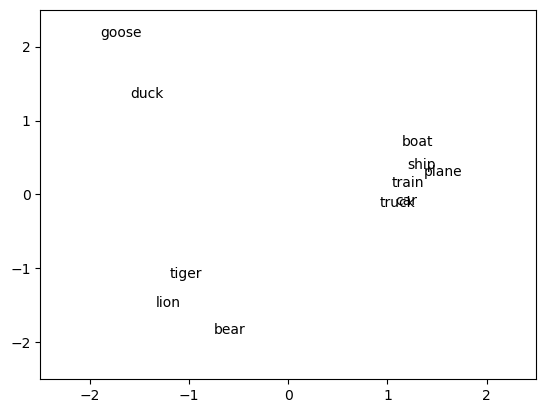

In [264]:
tokens = prompt.split(' ')[1:]
for i in range(len(tokens)):
    plt.text(coordinates[i,0],coordinates[i,1],tokens[i])
plt.xlim((-2.5,2.5))    
plt.ylim((-2.5,2.5))

In [265]:
prompt = " France Paris Germany Berlin Italy Rome Spain Madrid Belgium Brussels"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| France| -> 4881
| Paris| -> 6342
| Germany| -> 4486
| Berlin| -> 11307
| Italy| -> 8031
| Rome|  -> 10598
| Spain| -> 8602
| Madrid| -> 14708
| Belgium| -> 15664
| Brussels| -> 16445


In [266]:
embeddings=all_embeddings[input['input_ids'][0].cpu().numpy()]
embeddings.shape

(10, 768)

In [267]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)

(-2.0, 2.0)

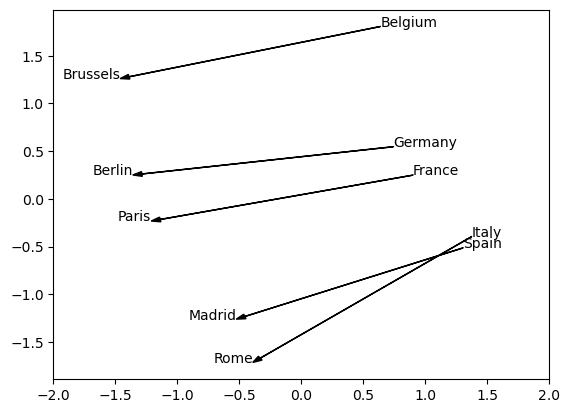

In [268]:
places = prompt.split(' ')[1:]
countries = [2*i for i in range(len(places)//2)]
cities = [2*i+1 for i in range(len(places)//2)]
for i in range(len(countries)):
    plt.arrow(coordinates[countries[i],0],coordinates[countries[i],1],coordinates[cities[i],0]-coordinates[countries[i],0],coordinates[cities[i],1]-coordinates[countries[i],1],color='black',head_width=0.05,length_includes_head=True)

for i,country in enumerate(countries):
    plt.text(coordinates[country,0],coordinates[country,1],places[country])
for i,city in enumerate(cities):
    plt.text(coordinates[city,0],coordinates[city,1],places[city], horizontalalignment='right')
plt.xlim((-2,2))

## Positional encoding

In [269]:
n=50
prompt = " test" * n # prompt = " test test test ....."
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332


In [270]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,
                       return_dict_in_generate=True, output_hidden_states=True)

In [271]:
len(output['hidden_states'][0])

13

In [272]:
pos_enc = output['hidden_states'][0][0][0].cpu().numpy()
pos_enc.shape

(50, 768)

In [273]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(pos_enc)
coordinates.shape

(50, 2)

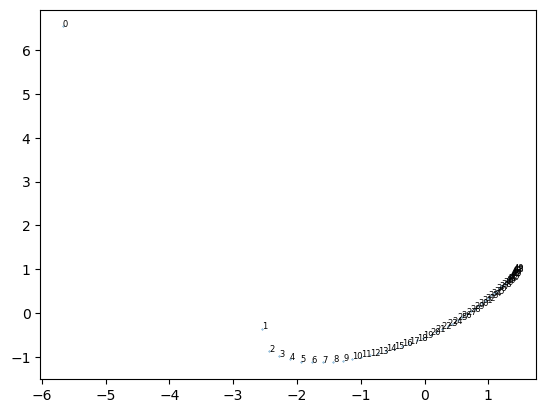

In [274]:
plt.scatter(coordinates[:,0],coordinates[:,1],s=.1)
for i in range(len(coordinates)):
    plt.text(coordinates[i,0],coordinates[i,1],str(i),fontsize=6)

# Transformers

In [275]:
prompt = "Now that the model is loaded, let's use it"

In [276]:
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')
tokens = [tokenizer.decode(token) for token in input['input_ids'][0]]

|token|  -> id

|Now|    -> 3844
| that|  -> 326
| the|   -> 262
| model| -> 2746
| is|    -> 318
| loaded| -> 9639
|,|      -> 11
| let|   -> 1309
|'s|     -> 338
| use|   -> 779
| it|    -> 340


In [277]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,
                          return_dict_in_generate=True, output_hidden_states=True, output_attentions=True)

In [278]:
attention = output['attentions'][0]

In [279]:
#head_view(attention, tokens) 

In [280]:
model_view(attention, tokens) 

<IPython.core.display.Javascript object>

(12, torch.Size([1, 12, 11, 11]))

In [304]:
scores=[]
token1 = 3 # "model"
#token2 = 5 # "loaded" 
token2 = 10 # "it"
#token2 = 9 # "use"
for layer in range(12):
    batch=0
    for head in range(12):
        att = float(attention[layer][batch,head,token2,token1].cpu())
        #print(f'layer {layer} head {head} -> {att:.3f}')
        scores.append((att,layer,head))
sorted(scores,reverse=True)

[(0.3418969213962555, 4, 3),
 (0.31072086095809937, 5, 10),
 (0.16174010932445526, 6, 7),
 (0.1546478122472763, 0, 6),
 (0.0908333957195282, 0, 11),
 (0.0843433141708374, 1, 10),
 (0.07888945192098618, 3, 5),
 (0.07540398836135864, 6, 0),
 (0.0706707313656807, 8, 8),
 (0.06729916483163834, 1, 6),
 (0.05982770025730133, 1, 4),
 (0.05874374136328697, 9, 0),
 (0.05256517603993416, 6, 1),
 (0.05194162204861641, 1, 7),
 (0.05112587288022041, 2, 10),
 (0.04957950860261917, 0, 2),
 (0.04369333013892174, 4, 6),
 (0.04304511100053787, 0, 9),
 (0.04262012243270874, 1, 3),
 (0.04093003273010254, 11, 11),
 (0.039910200983285904, 1, 2),
 (0.03922021761536598, 8, 9),
 (0.03826218098402023, 3, 4),
 (0.03682699427008629, 0, 0),
 (0.03559817373752594, 9, 8),
 (0.03531695529818535, 2, 7),
 (0.03439471870660782, 0, 10),
 (0.034045446664094925, 5, 9),
 (0.031861670315265656, 0, 4),
 (0.029990965500473976, 7, 8),
 (0.027883192524313927, 11, 5),
 (0.027637816965579987, 6, 4),
 (0.027134988456964493, 11, 8),

In [281]:
# Import specialized versions of models (that return query/key vectors)
from bertviz.transformers_neuron_view import GPT2Model, GPT2Tokenizer
from bertviz.neuron_view import show

In [301]:
# attention, nécessite un nouveau téléchargement !
tokenizer_Viz = GPT2Tokenizer.from_pretrained(model_name)
gpt2_Viz = GPT2Model.from_pretrained(model_name)

100%|██████████| 456318/456318 [00:00<00:00, 720842.81B/s]


In [303]:
show(gpt2_Viz, model_name, tokenizer_Viz, prompt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [248]:
model_name

'openai-community/gpt2'

 15%|█▍        | 80442368/548118077 [00:28<01:39, 4719770.33B/s]

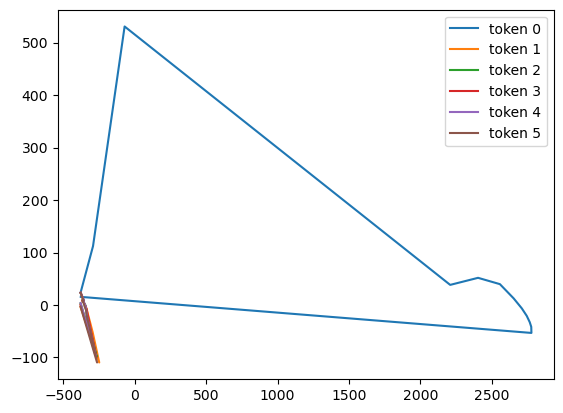

In [152]:
for i in range(6):
    plt.plot(coordinates[:,i,0],coordinates[:,i,1],label=f'token {i}')
plt.legend()

In [160]:
depositionned_hidden_states.reshape(13,6,768)[0].shape

(6, 768)

In [175]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(depositionned_hidden_states[:12,:])

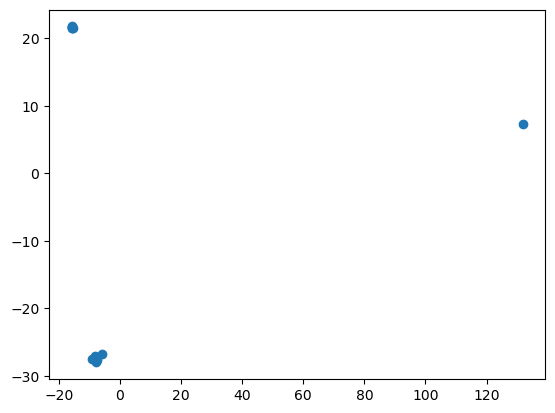

In [176]:
plt.scatter(coordinates[:,0],coordinates[:,1])

In [136]:
hidden_states[:2,:3,:4][1,2,:]

array([ 1.4723325 ,  0.31845966, -1.9891803 ,  0.6044718 ], dtype=float32)

In [126]:
#reshape hidden_layers to (2*3,4)
a=np.reshape(hidden_states[:2,:3,:4],(2*3,4))
a[]

array([[-2.1733351e-02, -4.3297827e-01,  1.5345451e-01,  1.0549580e-01],
       [-3.7680380e-04, -1.5540067e-02,  6.4822450e-02,  9.5407469e-03],
       [-6.4333685e-02, -1.1384800e-01,  7.9496771e-02,  1.3266746e-03],
       [ 4.1518506e-01, -1.6875958e+00,  3.3301681e-01,  2.5746953e-01],
       [-1.4354229e+00, -7.5898492e-01,  6.8326247e-01, -8.9052284e-01],
       [ 1.4723325e+00,  3.1845966e-01, -1.9891803e+00,  6.0447180e-01]],
      dtype=float32)

In [138]:
hidden_states[2,4]# layer 2, token 4

array([ 9.33552027e-01,  1.96178615e-01,  2.49331206e-01, -2.62963861e-01,
       -4.49798763e-01, -3.52900207e-01,  1.46176547e-01,  2.52551198e+00,
       -1.17002979e-01,  6.17567420e-01,  3.38278115e-01, -3.09932560e-01,
       -1.07729435e+00,  8.79825473e-01, -2.45518947e+00, -2.34148443e-01,
       -9.40730691e-01, -1.06031232e-01, -2.08239481e-01,  9.14701998e-01,
       -3.29496235e-01, -2.38071978e-02,  2.36085318e-02,  1.47219646e+00,
       -5.10117114e-01,  6.11197233e-01, -3.31257552e-01, -5.95601350e-02,
        6.79805219e-01,  5.40843844e-01, -1.31241882e+00,  1.07631004e+00,
        9.40440536e-01, -4.42849904e-01,  3.54316503e-01, -2.89333403e-01,
       -1.59750879e+00,  6.19172454e-02, -5.31370759e-01, -2.69558191e-01,
       -3.27479243e-02,  5.38637221e-01, -9.25411582e-01, -3.56997132e-01,
       -2.98595071e-01,  6.66533113e-02, -1.08645773e+00, -6.28482342e-01,
       -2.97763848e+00,  1.40697408e+00, -4.11673129e-01,  2.63248444e-01,
       -5.87743640e-01,  

In [296]:
from huggingface_hub import scan_cache_dir

In [298]:
gpt2.config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 50257
}